# Imports

In [79]:
import os
scripts_path = os.path.abspath('../scripts')
import importlib.util
spec = importlib.util.spec_from_file_location("helpers", os.path.join(scripts_path, "helpers.py"))
helpers = importlib.util.module_from_spec(spec)
spec.loader.exec_module(helpers)

import torch
import pandas as pd
from tqdm import trange

# Neural Network

## Convert 4th down

#### Data setup

In [80]:
X_train, X_test, y_train, y_test = helpers.convert_data_split(nn=True)

batch_size = 64
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train.values), torch.tensor(y_train))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=True)

X_test = torch.tensor(X_test.values)
y_test = torch.tensor(y_test)

n_train, p = X_train.shape
n_test, p = X_test.shape

#### Class

In [81]:
input_size = 4   # input size
hidden_size = 10  # width of hidden layer
output_size = 4   # number of output neurons

class NNClassifier(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.act = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, output_size)
        self.log_softmax = torch.nn.LogSoftmax()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        y_output = self.log_softmax(x)
        return y_output

#### Testing / Training

In [82]:
def train_one_epoch(train_loader, model, optimizer, log_interval, epoch):
    model.train()
    loss_function = torch.nn.CrossEntropyLoss()
    train_loss = 0
    num_correct = 0
    
    for i, (feature, label) in enumerate(train_loader):
        feature = feature.float()
        label = label.long()

        optimizer.zero_grad()
        ans = model(feature)
        loss = loss_function(ans, label)
        loss.backward()
        optimizer.step()

        pred = ans.argmax(dim=1, keepdim=True) # Get index of largest log-probability and use that as prediction
        num_correct += (pred == label.view_as(pred)).sum().item()
        train_loss += loss.item()
    
    return train_loss, num_correct

def test_one_epoch(X_test, Y_test, model):
    model.eval()
    loss_function = torch.nn.CrossEntropyLoss()
    test_loss = 0
    num_correct = 0
    
    with torch.no_grad():
        feature = X_test.float()
        label = Y_test.long()
        output = model(feature)
        
        pred = output.argmax(dim=1, keepdim=True) # Get index of largest log-probability and use that as prediction
        num_correct += (pred == label.view_as(pred)).sum().item()
        test_loss += torch.nn.functional.nll_loss(output, label.long(), reduction='sum').item()

    return test_loss, num_correct

#### Running

In [83]:
# Hyperparameters
lr = 0.0001
wd = 0.02
max_epochs = 2000

# Print results
log_interval = 20

model = NNClassifier()

# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

train_losses = []
train_correct_list = []
test_losses = []
test_correct_list = []

for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    train_loss, train_correct = train_one_epoch(train_loader, model, optimizer, log_interval, epoch)
    
    if epoch % log_interval == 0:
        test_loss, test_correct = test_one_epoch(X_test, y_test, model)

        # Record results
        train_losses.append(train_loss)
        train_correct_list.append(train_correct)
        test_losses.append(test_loss)
        test_correct_list.append(test_correct)
        
        print('cross entropy loss', train_loss / len(train_loader), test_loss / float(n_test))
        print('accuracy', train_correct / float(n_train), test_correct / float(n_test))

Epochs:   0%|          | 0/2000 [00:00<?, ?it/s]/var/folders/8r/q18lgzp95917cyrn8bqmq1c80000gn/T/ipykernel_68606/201985438.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_output = self.log_softmax(x)
Epochs:   0%|          | 1/2000 [00:03<1:42:49,  3.09s/it]

cross entropy loss 8.270278773340237 1.5947190472691322
accuracy 0.1923241394056019 0.13296280461735785


Epochs:   1%|          | 21/2000 [00:42<1:00:57,  1.85s/it]

cross entropy loss 1.3862397630198473 1.3882737765204147
accuracy 0.12080393414581997 0.11500641299700727


Epochs:   2%|▏         | 41/2000 [01:18<56:49,  1.74s/it]  

cross entropy loss 1.37887391508842 1.3789438261543394
accuracy 0.1230489630104768 0.115861479264643


Epochs:   3%|▎         | 61/2000 [01:53<56:32,  1.75s/it]

cross entropy loss 1.3730635245641072 1.3755389046801518
accuracy 0.12700449005772932 0.11928174433518597


Epochs:   4%|▍         | 81/2000 [02:28<55:51,  1.75s/it]

cross entropy loss 1.3681126930275742 1.3688819758042967
accuracy 0.12999786187727175 0.12612227447627192


Epochs:   5%|▌         | 101/2000 [03:03<55:42,  1.76s/it]

cross entropy loss 1.3660909424022751 1.3646258500561137
accuracy 0.13170836005986744 0.12954253954681488


Epochs:   6%|▌         | 121/2000 [03:39<57:45,  1.84s/it]

cross entropy loss 1.3638425368030056 1.362191019633123
accuracy 0.13491554415223433 0.13253527148353997


Epochs:   7%|▋         | 141/2000 [04:14<54:11,  1.75s/it]

cross entropy loss 1.3553366093408494 1.3573431738323
accuracy 0.14817190506735087 0.13894826849080805


Epochs:   8%|▊         | 161/2000 [04:49<53:33,  1.75s/it]

cross entropy loss 1.307277376959924 1.307241530334812
accuracy 0.23455206328843275 0.21675929884566053


Epochs:   9%|▉         | 181/2000 [05:28<57:59,  1.91s/it]  

cross entropy loss 1.285899854030739 1.2534104535191322
accuracy 0.26822749625828524 0.25480974775545107


Epochs:  10%|█         | 201/2000 [06:06<56:47,  1.89s/it]

cross entropy loss 1.3173281505805294 1.2751644374265176
accuracy 0.2030147530468249 0.23899102180418982


Epochs:  11%|█         | 221/2000 [06:45<56:26,  1.90s/it]

cross entropy loss 1.2307444028302925 1.3489223576448268
accuracy 0.339213170836006 0.14749893116716545


Epochs:  12%|█▏        | 241/2000 [07:23<55:56,  1.91s/it]

cross entropy loss 1.2508429305083086 1.2429127197787515
accuracy 0.3061791746846269 0.2620778110303549


Epochs:  13%|█▎        | 261/2000 [08:02<57:07,  1.97s/it]

cross entropy loss 1.1857198359203986 1.2591962418835507
accuracy 0.3830446867650203 0.24326635314236852


Epochs:  14%|█▍        | 281/2000 [08:40<54:23,  1.90s/it]

cross entropy loss 1.1348123724768762 1.7264662632936083
accuracy 0.428907419285867 0.6117999144933732


Epochs:  15%|█▌        | 301/2000 [09:18<53:10,  1.88s/it]

cross entropy loss 1.0580921367723115 1.043015615814718
accuracy 0.49807568954457987 0.46472851646002566


Epochs:  16%|█▌        | 321/2000 [09:57<54:28,  1.95s/it]

cross entropy loss 0.9605038376892505 1.2567032727995404
accuracy 0.5667094291212316 0.26378794356562635


Epochs:  17%|█▋        | 341/2000 [10:35<51:13,  1.85s/it]

cross entropy loss 0.8710468516868799 1.1193783985544037
accuracy 0.603592046183451 0.44164172723386064


Epochs:  18%|█▊        | 361/2000 [11:13<52:18,  1.92s/it]

cross entropy loss 0.8506855275355228 0.9965927822052694
accuracy 0.6082959161855891 0.566053869174861


Epochs:  19%|█▉        | 381/2000 [11:52<51:33,  1.91s/it]

cross entropy loss 0.8424914767142055 1.101488808986212
accuracy 0.6090442591404747 0.4467721248396751


Epochs:  20%|██        | 401/2000 [12:30<50:56,  1.91s/it]

cross entropy loss 0.8353539928287065 1.0836494253353464
accuracy 0.611075475732307 0.4433518597691321


Epochs:  21%|██        | 421/2000 [13:09<52:16,  1.99s/it]

cross entropy loss 0.8304359422249048 1.0376170705964087
accuracy 0.6116100064143681 0.47669944420692606


Epochs:  22%|██▏       | 441/2000 [13:48<49:53,  1.92s/it]

cross entropy loss 0.8289966899521497 0.9486396597103463
accuracy 0.6113961941415437 0.5651988029072254


Epochs:  23%|██▎       | 461/2000 [14:27<49:50,  1.94s/it]

cross entropy loss 0.8260470470603631 0.9592087881439718
accuracy 0.6126790677784905 0.5489525438221462


Epochs:  24%|██▍       | 481/2000 [15:06<49:20,  1.95s/it]

cross entropy loss 0.8238103677626369 0.9351331197894399
accuracy 0.6120376309600171 0.5669089354424968


Epochs:  25%|██▌       | 501/2000 [15:41<40:05,  1.60s/it]

cross entropy loss 0.8219797461211276 0.9209412325646644
accuracy 0.6126790677784905 0.5788798631893972


Epochs:  26%|██▌       | 521/2000 [38:13<15:26:54, 37.60s/it]  

cross entropy loss 0.8203094707054346 0.8981264529446344
accuracy 0.6125721616420783 0.5925609234715691


Epochs:  27%|██▋       | 541/2000 [1:02:05<5:59:57, 14.80s/it]   

cross entropy loss 0.8197975300607228 0.8681518502498397
accuracy 0.6143895659610862 0.6079521162890124


Epochs:  28%|██▊       | 561/2000 [1:02:49<57:32,  2.40s/it]  

cross entropy loss 0.8174101929275357 0.8789267081284737
accuracy 0.6142826598246739 0.5998289867464729


Epochs:  29%|██▉       | 581/2000 [1:03:39<55:43,  2.36s/it]  

cross entropy loss 0.8173107253450925 0.8643437157639483
accuracy 0.6161000641436819 0.6117999144933732


Epochs:  30%|███       | 601/2000 [1:04:25<45:29,  1.95s/it]  

cross entropy loss 0.8140771141668566 0.8680947031817817
accuracy 0.6162069702800941 0.6083796494228303


Epochs:  31%|███       | 621/2000 [1:05:06<45:49,  1.99s/it]

cross entropy loss 0.8133436064330899 0.862720739031103
accuracy 0.6170622193713919 0.6113723813595554


Epochs:  32%|███▏      | 641/2000 [1:05:47<46:22,  2.05s/it]

cross entropy loss 0.812047469372652 0.8608328504101646
accuracy 0.616634594825743 0.6122274476271911


Epochs:  33%|███▎      | 661/2000 [1:06:26<44:22,  1.99s/it]

cross entropy loss 0.8112427726083872 0.8553017448696024
accuracy 0.6173829377806286 0.6156477126977341


Epochs:  34%|███▍      | 681/2000 [1:07:05<41:59,  1.91s/it]

cross entropy loss 0.8111443860190255 0.8592502158541311
accuracy 0.6171691255078041 0.6143651132962804


Epochs:  35%|███▌      | 701/2000 [1:38:24<5:08:28, 14.25s/it]   

cross entropy loss 0.809496647646638 0.8565326770588393
accuracy 0.6171691255078041 0.6143651132962804


Epochs:  36%|███▌      | 721/2000 [1:39:07<49:10,  2.31s/it]  

cross entropy loss 0.8086118957623333 0.8545900942576956
accuracy 0.6179174684626898 0.6143651132962804


Epochs:  37%|███▋      | 741/2000 [1:39:56<49:09,  2.34s/it]

cross entropy loss 0.8083308464815827 0.8524496625661341
accuracy 0.6177036561898653 0.6165027789653699


Epochs:  38%|███▊      | 761/2000 [1:40:42<49:01,  2.37s/it]

cross entropy loss 0.8072075276147752 0.8321382898507642
accuracy 0.618024374599102 0.6182129115006413


Epochs:  39%|███▉      | 781/2000 [1:41:30<47:10,  2.32s/it]

cross entropy loss 0.8059748224660653 0.8318034967534202
accuracy 0.618024374599102 0.6182129115006413


Epochs:  40%|████      | 801/2000 [1:42:17<48:16,  2.42s/it]

cross entropy loss 0.7240043967759529 0.7304100372588446
accuracy 0.7265341030575155 0.7293715262932877


Epochs:  41%|████      | 821/2000 [1:43:05<45:42,  2.33s/it]

cross entropy loss 0.7192417093280221 0.7342218249819634
accuracy 0.7309172546504169 0.7486105173150919


Epochs:  42%|████▏     | 841/2000 [1:43:52<46:36,  2.41s/it]

cross entropy loss 0.7054767450507806 0.7293962117391246
accuracy 0.7385075903356852 0.7554510474561779


Epochs:  43%|████▎     | 861/2000 [1:44:39<43:41,  2.30s/it]

cross entropy loss 0.6980141697286748 0.7309933026767582
accuracy 0.741180243745991 0.7592988456605387


Epochs:  44%|████▍     | 881/2000 [1:45:26<44:57,  2.41s/it]

cross entropy loss 0.6965543463522074 0.7591980685021644
accuracy 0.7415009621552278 0.7332193244976486


Epochs:  45%|████▌     | 901/2000 [1:46:14<42:22,  2.31s/it]

cross entropy loss 0.6924890174346716 0.7338851530769025
accuracy 0.7438528971562968 0.7614365113296281


Epochs:  46%|████▌     | 921/2000 [1:47:01<42:57,  2.39s/it]

cross entropy loss 0.6910739109224203 0.7231340934293502
accuracy 0.7442805217019457 0.7605814450619923


Epochs:  47%|████▋     | 941/2000 [1:47:48<41:07,  2.33s/it]

cross entropy loss 0.6902448948548765 0.7233167552907225
accuracy 0.7454564892024802 0.7614365113296281


Epochs:  48%|████▊     | 961/2000 [2:02:43<40:22:08, 139.87s/it]

cross entropy loss 0.6868288638640423 0.718942629980093
accuracy 0.7465255505666025 0.7622915775972637


Epochs:  49%|████▉     | 981/2000 [3:00:59<5:21:58, 18.96s/it]    

cross entropy loss 0.693125842177138 0.7177864847758123
accuracy 0.7440667094291212 0.7640017101325353


Epochs:  50%|█████     | 1001/2000 [3:01:39<34:42,  2.08s/it] 

cross entropy loss 0.6914580496801 0.7162730529706872
accuracy 0.7443874278383579 0.764856776400171


Epochs:  51%|█████     | 1021/2000 [5:03:15<1:57:39,  7.21s/it]    

cross entropy loss 0.6859995917398103 0.7133063112073803
accuracy 0.7448150523840068 0.7635741769987174


Epochs:  52%|█████▏    | 1041/2000 [5:04:00<39:06,  2.45s/it]  

cross entropy loss 0.68254898721669 0.7106625156149797
accuracy 0.7472738935214881 0.7622915775972637


Epochs:  53%|█████▎    | 1061/2000 [5:04:47<34:42,  2.22s/it]

cross entropy loss 0.6832791110690759 0.7159040238216118
accuracy 0.7480222364763738 0.7605814450619923


Epochs:  54%|█████▍    | 1081/2000 [5:05:34<35:22,  2.31s/it]

cross entropy loss 0.6778883528547223 0.7128594681053602
accuracy 0.7497327346589694 0.7627191107310817


Epochs:  55%|█████▌    | 1101/2000 [5:06:20<36:08,  2.41s/it]

cross entropy loss 0.6776151523298147 0.7108009733059
accuracy 0.7491982039769083 0.7631466438648995


Epochs:  56%|█████▌    | 1121/2000 [5:07:08<34:54,  2.38s/it]

cross entropy loss 0.6815725317617662 0.7141923256132429
accuracy 0.7501603592046183 0.7618640444634459


Epochs:  57%|█████▋    | 1141/2000 [5:07:54<32:34,  2.28s/it]

cross entropy loss 0.6792828266312476 0.7091028442643758
accuracy 0.7501603592046183 0.7631466438648995


Epochs:  58%|█████▊    | 1161/2000 [5:08:38<31:25,  2.25s/it]

cross entropy loss 0.6761949810446525 0.7100563913698429
accuracy 0.7516570451143896 0.7627191107310817


Epochs:  59%|█████▉    | 1181/2000 [5:09:21<29:13,  2.14s/it]

cross entropy loss 0.6764418458452031 0.6852658366790028
accuracy 0.7526192003420996 0.7635741769987174


Epochs:  60%|██████    | 1201/2000 [5:10:06<28:27,  2.14s/it]

cross entropy loss 0.6959856132260797 0.7098788962296921
accuracy 0.7483429548856104 0.748182984181274


Epochs:  61%|██████    | 1221/2000 [5:10:52<29:48,  2.30s/it]

cross entropy loss 0.6716232729606888 0.6830030737294249
accuracy 0.7530468248877485 0.7640017101325353


Epochs:  62%|██████▏   | 1241/2000 [5:11:36<28:47,  2.28s/it]

cross entropy loss 0.6705053606811835 0.6837800129094965
accuracy 0.7543296985246953 0.7669944420692604


Epochs:  63%|██████▎   | 1261/2000 [5:12:20<27:02,  2.20s/it]

cross entropy loss 0.6696951470407498 0.708685592383898
accuracy 0.7543296985246953 0.7524583155194527


Epochs:  64%|██████▍   | 1281/2000 [5:13:05<26:38,  2.22s/it]

cross entropy loss 0.6698865918886094 0.7066415539660378
accuracy 0.7544366046611075 0.7528858486532707


Epochs:  65%|██████▌   | 1301/2000 [5:13:50<26:23,  2.27s/it]

cross entropy loss 0.6900349074885959 0.6736095048464888
accuracy 0.7510156082959162 0.7669944420692604


Epochs:  66%|██████▌   | 1321/2000 [5:14:34<24:19,  2.15s/it]

cross entropy loss 0.6675006355963596 0.6871140615814718
accuracy 0.7541158862518709 0.7652843095339888


Epochs:  67%|██████▋   | 1341/2000 [5:15:19<24:13,  2.21s/it]

cross entropy loss 0.6654897725501028 0.7174050868092667
accuracy 0.7541158862518709 0.7469003847798205


Epochs:  68%|██████▊   | 1361/2000 [5:16:03<23:28,  2.20s/it]

cross entropy loss 0.6677876433142188 1.2045672980573963
accuracy 0.7528330126149241 0.4946558358272766


Epochs:  69%|██████▉   | 1381/2000 [5:16:47<22:52,  2.22s/it]

cross entropy loss 0.6636903555620284 0.7215428998603837
accuracy 0.7553987598888177 0.7490380504489098


Epochs:  70%|███████   | 1401/2000 [5:17:31<22:27,  2.25s/it]

cross entropy loss 0.6678815275227943 1.0867609396710667
accuracy 0.7539020739790464 0.5446772124839675


Epochs:  71%|███████   | 1421/2000 [5:18:13<20:29,  2.12s/it]

cross entropy loss 0.6677116508386574 0.9164890845446773
accuracy 0.7531537310241608 0.5878580589995724


Epochs:  72%|███████▏  | 1441/2000 [5:18:56<19:55,  2.14s/it]

cross entropy loss 0.6631969294580472 0.871389401269907
accuracy 0.7527261064785119 0.6143651132962804


Epochs:  73%|███████▎  | 1461/2000 [5:19:38<18:12,  2.03s/it]

cross entropy loss 0.6633669024422055 0.8172894983833904
accuracy 0.7516570451143896 0.6545532278751603


Epochs:  74%|███████▍  | 1481/2000 [5:20:20<18:33,  2.15s/it]

cross entropy loss 0.6578316510129137 0.7925866735751123
accuracy 0.7549711353431687 0.6737922188969645


Epochs:  75%|███████▌  | 1501/2000 [5:21:00<16:55,  2.04s/it]

cross entropy loss 0.6526650541088208 0.7515562790588927
accuracy 0.7568954457985888 0.7126977340743907


Epochs:  76%|███████▌  | 1521/2000 [5:21:41<15:47,  1.98s/it]

cross entropy loss 0.6501514785954742 0.7347849454060229
accuracy 0.7570023519350011 0.728516460025652


Epochs:  77%|███████▋  | 1541/2000 [5:22:22<15:51,  2.07s/it]

cross entropy loss 0.6505548179555102 0.7441290912081819
accuracy 0.7575368826170622 0.7195382642154767


Epochs:  78%|███████▊  | 1561/2000 [5:23:01<14:35,  1.99s/it]

cross entropy loss 0.6480516140558281 0.8441625548611853
accuracy 0.7584990378447722 0.68875587858059


Epochs:  79%|███████▉  | 1581/2000 [5:23:42<14:15,  2.04s/it]

cross entropy loss 0.6465290138105146 0.744332419954441
accuracy 0.7592473807996579 0.715262932877298


Epochs:  80%|████████  | 1601/2000 [5:24:28<16:10,  2.43s/it]

cross entropy loss 0.6461656328772201 0.7460815377498397
accuracy 0.7587128501175967 0.7139803334758443


Epochs:  81%|████████  | 1621/2000 [5:25:14<15:10,  2.40s/it]

cross entropy loss 0.6459682506768882 0.8367704902769613
accuracy 0.7584990378447722 0.6930312099187687


Epochs:  82%|████████▏ | 1641/2000 [5:26:03<14:38,  2.45s/it]

cross entropy loss 0.6447616489160628 0.8321615661908134
accuracy 0.7594611930724824 0.6947413424540402


Epochs:  83%|████████▎ | 1661/2000 [5:26:50<13:19,  2.36s/it]

cross entropy loss 0.6436780790487925 0.8263577725857738
accuracy 0.7593542869360701 0.6968790081231295


Epochs:  84%|████████▍ | 1681/2000 [5:27:36<12:04,  2.27s/it]

cross entropy loss 0.6428062404905047 0.8238848441174113
accuracy 0.7604233483001924 0.6968790081231295


Epochs:  85%|████████▌ | 1701/2000 [5:28:23<11:50,  2.38s/it]

cross entropy loss 0.6422838617344292 0.8207330919830857
accuracy 0.7608509728458414 0.6973065412569475


Epochs:  86%|████████▌ | 1721/2000 [5:29:10<10:52,  2.34s/it]

cross entropy loss 0.6412041282572714 0.8171559986572787
accuracy 0.7615993158007269 0.6998717400598546


Epochs:  87%|████████▋ | 1741/2000 [5:29:57<09:52,  2.29s/it]

cross entropy loss 0.640417352825606 0.8178077361786554
accuracy 0.7608509728458414 0.6990166737922189


Epochs:  88%|████████▊ | 1761/2000 [5:30:43<09:25,  2.37s/it]

cross entropy loss 0.6401641020158522 0.8205126974000642
accuracy 0.761171691255078 0.695168875587858


Epochs:  89%|████████▉ | 1781/2000 [5:31:29<08:21,  2.29s/it]

cross entropy loss 0.6395075315115403 0.8225888321164226
accuracy 0.7620269403463759 0.6947413424540402


Epochs:  90%|█████████ | 1801/2000 [5:32:16<07:35,  2.29s/it]

cross entropy loss 0.6392188613512078 0.821426006706926
accuracy 0.7623476587556126 0.6960239418554938


Epochs:  91%|█████████ | 1821/2000 [5:33:03<06:57,  2.33s/it]

cross entropy loss 0.6382678714739222 0.8199206642128046
accuracy 0.762989095574086 0.6964514749893117


Epochs:  92%|█████████▏| 1841/2000 [5:33:49<06:05,  2.30s/it]

cross entropy loss 0.6370452612030263 0.8172157551804992
accuracy 0.7637374385289716 0.6968790081231295


Epochs:  93%|█████████▎| 1861/2000 [5:34:35<05:29,  2.37s/it]

cross entropy loss 0.6363176654796211 0.8183057246018598
accuracy 0.7642719692110327 0.6964514749893117


Epochs:  94%|█████████▍| 1881/2000 [5:35:21<04:35,  2.31s/it]

cross entropy loss 0.635795899394418 0.8162677923090798
accuracy 0.7645926876202694 0.6968790081231295


Epochs:  95%|█████████▌| 1901/2000 [5:36:08<03:52,  2.35s/it]

cross entropy loss 0.6354213063003255 0.8162914339728516
accuracy 0.764378875347445 0.6968790081231295


Epochs:  96%|█████████▌| 1921/2000 [5:37:16<06:31,  4.96s/it]

cross entropy loss 0.6343302998413034 0.8158370756399637
accuracy 0.7645926876202694 0.6968790081231295


Epochs:  97%|█████████▋| 1941/2000 [5:38:12<03:37,  3.68s/it]

cross entropy loss 0.6337339531402199 0.8167684423765498
accuracy 0.7652341244387428 0.6968790081231295


Epochs:  98%|█████████▊| 1961/2000 [5:39:24<01:45,  2.72s/it]

cross entropy loss 0.6326171950418122 0.8166233566695169
accuracy 0.7655548428479795 0.6968790081231295


Epochs:  99%|█████████▉| 1981/2000 [5:40:47<00:53,  2.82s/it]

cross entropy loss 0.6326675936072862 0.8148377065018437
accuracy 0.7652341244387428 0.6968790081231295


Epochs: 100%|██████████| 2000/2000 [5:42:15<00:00, 10.27s/it]


#### Results

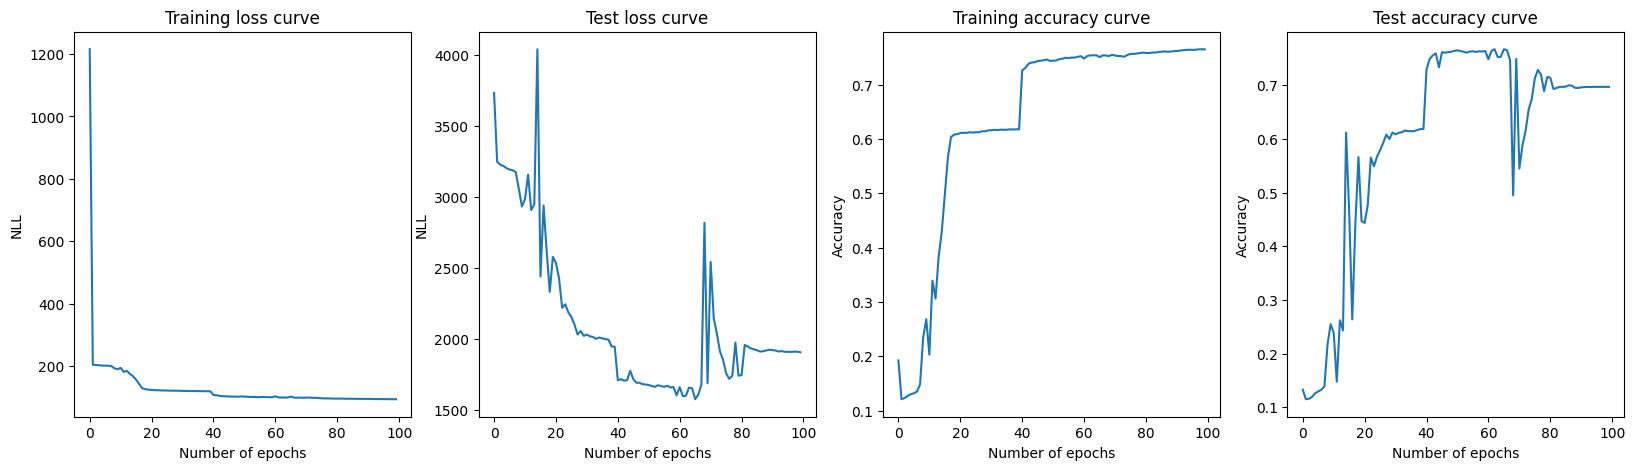

In [84]:
from matplotlib import pyplot

fig, axes = pyplot.subplots(ncols=4, figsize=(20, 5), sharey=False)

axes[0].set_xlabel('Number of epochs')
axes[0].set_ylabel('NLL')
axes[0].plot(range(0,len(train_losses)), train_losses)
axes[0].set_title('Training loss curve')

axes[1].set_xlabel('Number of epochs')
axes[1].set_ylabel('NLL')
axes[1].plot(range(0,len(train_losses)), test_losses)
axes[1].set_title('Test loss curve')

axes[2].set_xlabel('Number of epochs')
axes[2].set_ylabel('Accuracy')
axes[2].plot(range(0,len(train_losses)), list(map(lambda x : x/float(n_train), train_correct_list)))
axes[2].set_title('Training accuracy curve')

axes[3].set_xlabel('Number of epochs')
axes[3].set_ylabel('Accuracy')
axes[3].plot(range(0,len(train_losses)), list(map(lambda x : x/float(n_test), test_correct_list)))
axes[3].set_title('Test accuracy curve')
pyplot.show()

## Attempt 4th down

#### Data setup

In [89]:
X_train, X_test, y_train, y_test = helpers.attempt_data_split(nn=True)

batch_size = 64
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train.values), torch.tensor(y_train))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=True)

X_test = torch.tensor(X_test.values)
y_test = torch.tensor(y_test)

n_train, p = X_train.shape
n_test, p = X_test.shape

#### Class

In [90]:
input_size = 4   # input size
hidden_size = 10  # width of hidden layer
output_size = 3   # number of output neurons

class NNClassifier(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.act = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, output_size)
        self.log_softmax = torch.nn.LogSoftmax()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        y_output = self.log_softmax(x)
        return y_output

#### Testing / Training

In [91]:
def train_one_epoch(train_loader, model, optimizer, log_interval, epoch):
    model.train()
    loss_function = torch.nn.CrossEntropyLoss()
    train_loss = 0
    num_correct = 0
    
    for i, (feature, label) in enumerate(train_loader):
        feature = feature.float()
        label = label.long()

        optimizer.zero_grad()
        ans = model(feature)
        loss = loss_function(ans, label)
        loss.backward()
        optimizer.step()

        pred = ans.argmax(dim=1, keepdim=True) # Get index of largest log-probability and use that as prediction
        num_correct += (pred == label.view_as(pred)).sum().item()
        train_loss += loss.item()
    
    return train_loss, num_correct

def test_one_epoch(X_test, Y_test, model):
    model.eval()
    loss_function = torch.nn.CrossEntropyLoss()
    test_loss = 0
    num_correct = 0
    
    with torch.no_grad():
        feature = X_test.float()
        label = Y_test.long()
        output = model(feature)
        
        pred = output.argmax(dim=1, keepdim=True) # Get index of largest log-probability and use that as prediction
        num_correct += (pred == label.view_as(pred)).sum().item()
        test_loss += torch.nn.functional.nll_loss(output, label.long(), reduction='sum').item()

    return test_loss, num_correct

#### Running

In [94]:
# Hyperparameters
lr = 0.0001
wd = 0.02
max_epochs = 1000

# Print results
log_interval = 20

model = NNClassifier()

# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

train_losses = []
train_correct_list = []
test_losses = []
test_correct_list = []

for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    train_loss, train_correct = train_one_epoch(train_loader, model, optimizer, log_interval, epoch)
    
    if epoch % log_interval == 0:
        test_loss, test_correct = test_one_epoch(X_test, y_test, model)

        # Record results
        train_losses.append(train_loss)
        train_correct_list.append(train_correct)
        test_losses.append(test_loss)
        test_correct_list.append(test_correct)
        
        print('cross entropy loss', train_loss / len(train_loader), test_loss / float(n_test))
        print('accuracy', train_correct / float(n_train), test_correct / float(n_test))

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/8r/q18lgzp95917cyrn8bqmq1c80000gn/T/ipykernel_68606/3132185011.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_output = self.log_softmax(x)
Epochs:   0%|          | 1/1000 [00:02<34:17,  2.06s/it]

cross entropy loss 5.61249728308243 1.184569686230761
accuracy 0.24224930511011333 0.1633176571184267


Epochs:   2%|▏         | 21/1000 [00:36<28:16,  1.73s/it]

cross entropy loss 1.1003460657028925 1.1017757446758765
accuracy 0.16891169553132349 0.1628901239846088


Epochs:   4%|▍         | 41/1000 [01:11<27:33,  1.72s/it]

cross entropy loss 1.0993554762431554 1.099566684313542
accuracy 0.17083600598674364 0.1658828559213339


Epochs:   6%|▌         | 61/1000 [01:46<27:41,  1.77s/it]

cross entropy loss 1.0990601745592494 1.099088632127779
accuracy 0.1710498182595681 0.16802052159042324


Epochs:   8%|▊         | 81/1000 [02:21<26:23,  1.72s/it]

cross entropy loss 1.0988797079138204 1.0989288290936297
accuracy 0.17137053666880478 0.168875587858059


Epochs:  10%|█         | 101/1000 [02:56<26:23,  1.76s/it]

cross entropy loss 1.0987759771801175 1.0988616095286448
accuracy 0.17169125507804148 0.16973065412569474


Epochs:  12%|█▏        | 121/1000 [03:31<25:29,  1.74s/it]

cross entropy loss 1.098704651099484 1.0988489797656584
accuracy 0.1717981612144537 0.17015818725951262


Epochs:  14%|█▍        | 141/1000 [04:05<24:26,  1.71s/it]

cross entropy loss 1.0986538046882266 1.0988262253166416
accuracy 0.1717981612144537 0.17015818725951262


Epochs:  16%|█▌        | 161/1000 [04:39<24:06,  1.72s/it]

cross entropy loss 1.0986239042411856 1.0987971037970286
accuracy 0.17190506735086594 0.17015818725951262


Epochs:  18%|█▊        | 181/1000 [05:14<23:16,  1.70s/it]

cross entropy loss 1.098609006323782 1.0987761237775224
accuracy 0.1721188796236904 0.17015818725951262


Epochs:  20%|██        | 201/1000 [05:48<22:54,  1.72s/it]

cross entropy loss 1.0985996690737148 1.0987619283414387
accuracy 0.17222578576010264 0.17015818725951262


Epochs:  22%|██▏       | 221/1000 [06:22<22:24,  1.73s/it]

cross entropy loss 1.0985936315692202 1.0987479416617678
accuracy 0.17222578576010264 0.17015818725951262


Epochs:  24%|██▍       | 241/1000 [07:01<26:15,  2.08s/it]

cross entropy loss 1.0985869209782606 1.0987365644372595
accuracy 0.17222578576010264 0.17058572039333048


Epochs:  26%|██▌       | 261/1000 [07:40<24:09,  1.96s/it]

cross entropy loss 1.098580661274138 1.0987262309948163
accuracy 0.17222578576010264 0.17058572039333048


Epochs:  28%|██▊       | 281/1000 [08:20<23:44,  1.98s/it]

cross entropy loss 1.0985747616307264 1.0987152712831338
accuracy 0.17222578576010264 0.17058572039333048


Epochs:  30%|███       | 301/1000 [08:58<21:28,  1.84s/it]

cross entropy loss 1.098569554536521 1.098701910872702
accuracy 0.17222578576010264 0.17058572039333048


Epochs:  32%|███▏      | 321/1000 [09:34<20:20,  1.80s/it]

cross entropy loss 1.0985607695417339 1.0986859410071077
accuracy 0.1721188796236904 0.17058572039333048


Epochs:  34%|███▍      | 341/1000 [10:11<19:35,  1.78s/it]

cross entropy loss 1.098544259460605 1.0986685098466225
accuracy 0.1721188796236904 0.17058572039333048


Epochs:  36%|███▌      | 361/1000 [10:46<18:29,  1.74s/it]

cross entropy loss 1.0985298691963663 1.0986524356028218
accuracy 0.1721188796236904 0.17058572039333048


Epochs:  38%|███▊      | 381/1000 [11:20<17:47,  1.72s/it]

cross entropy loss 1.0985196042223042 1.0986375095192924
accuracy 0.17222578576010264 0.17058572039333048


Epochs:  40%|████      | 401/1000 [11:55<17:07,  1.72s/it]

cross entropy loss 1.0985102596737089 1.0986274892114685
accuracy 0.17222578576010264 0.17058572039333048


Epochs:  42%|████▏     | 421/1000 [12:29<17:21,  1.80s/it]

cross entropy loss 1.0985012743748774 1.0986206002498398
accuracy 0.17233269189651487 0.17058572039333048


Epochs:  44%|████▍     | 441/1000 [13:06<16:02,  1.72s/it]

cross entropy loss 1.0984955855778284 1.0986116237240808
accuracy 0.17233269189651487 0.17058572039333048


Epochs:  46%|████▌     | 461/1000 [13:41<15:20,  1.71s/it]

cross entropy loss 1.0984896453870396 1.0986064048137558
accuracy 0.17233269189651487 0.17058572039333048


Epochs:  48%|████▊     | 481/1000 [14:15<14:55,  1.73s/it]

cross entropy loss 1.0984840125453716 1.0986019165508765
accuracy 0.17233269189651487 0.17058572039333048


Epochs:  50%|█████     | 501/1000 [14:49<14:09,  1.70s/it]

cross entropy loss 1.0984785475698458 1.0985985764482684
accuracy 0.17233269189651487 0.17058572039333048


Epochs:  52%|█████▏    | 521/1000 [15:26<14:48,  1.85s/it]

cross entropy loss 1.0984672997273555 1.098598889582888
accuracy 0.17233269189651487 0.17058572039333048


Epochs:  54%|█████▍    | 541/1000 [16:03<13:03,  1.71s/it]

cross entropy loss 1.0984368932490447 1.0986125631279393
accuracy 0.17233269189651487 0.17058572039333048


Epochs:  56%|█████▌    | 561/1000 [16:37<12:18,  1.68s/it]

cross entropy loss 1.0984262868660648 1.0986116237240808
accuracy 0.17233269189651487 0.17058572039333048


Epochs:  58%|█████▊    | 581/1000 [17:11<12:51,  1.84s/it]

cross entropy loss 1.0983397774144905 1.098671536814611
accuracy 0.17243959803292708 0.17058572039333048


Epochs:  60%|██████    | 601/1000 [17:46<11:23,  1.71s/it]

cross entropy loss 1.0983329313952908 1.0986375095192924
accuracy 0.17243959803292708 0.17058572039333048


Epochs:  61%|██████▏   | 613/1000 [18:07<11:26,  1.77s/it]


KeyboardInterrupt: 

#### Results

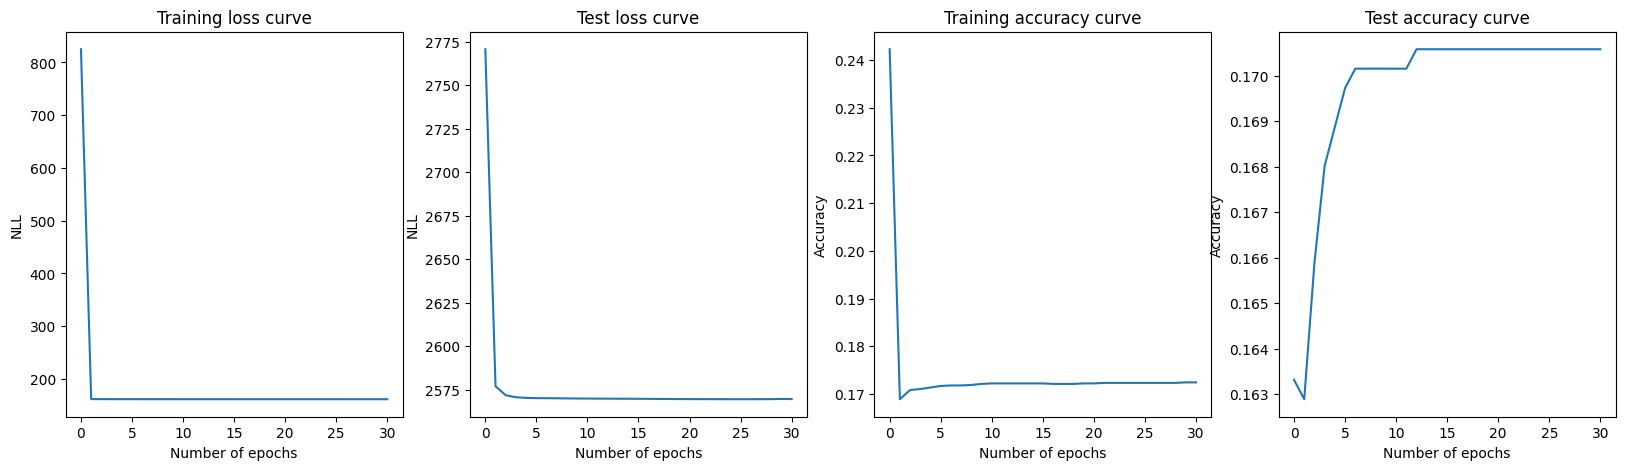

In [95]:
from matplotlib import pyplot

fig, axes = pyplot.subplots(ncols=4, figsize=(20, 5), sharey=False)

axes[0].set_xlabel('Number of epochs')
axes[0].set_ylabel('NLL')
axes[0].plot(range(0,len(train_losses)), train_losses)
axes[0].set_title('Training loss curve')

axes[1].set_xlabel('Number of epochs')
axes[1].set_ylabel('NLL')
axes[1].plot(range(0,len(train_losses)), test_losses)
axes[1].set_title('Test loss curve')

axes[2].set_xlabel('Number of epochs')
axes[2].set_ylabel('Accuracy')
axes[2].plot(range(0,len(train_losses)), list(map(lambda x : x/float(n_train), train_correct_list)))
axes[2].set_title('Training accuracy curve')

axes[3].set_xlabel('Number of epochs')
axes[3].set_ylabel('Accuracy')
axes[3].plot(range(0,len(train_losses)), list(map(lambda x : x/float(n_test), test_correct_list)))
axes[3].set_title('Test accuracy curve')
pyplot.show()